# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 2 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform the simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

In [3]:
# define pulse parameters
lambda0 = 0.5
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
min_steps_per_wvl = 30
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    run_time=1e-12,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

[13:22:38] WARNING  No sources in simulation.                               ]8;id=133195;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=642159;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#427\427]8;;\

/home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/mesher.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.str_ind = None


<Figure size 720x432 with 6 Axes>

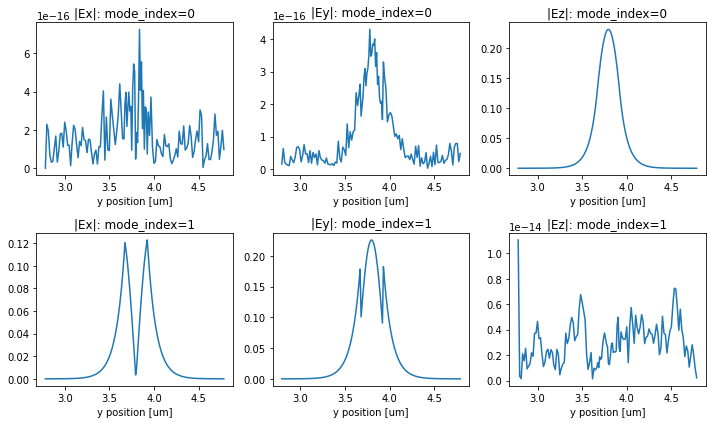

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data.fields.Ex.sel(mode_index=0).abs).plot(ax=ax1)
abs(mode_data.fields.Ey.sel(mode_index=0).abs).plot(ax=ax2)
abs(mode_data.fields.Ez.sel(mode_index=0).abs).plot(ax=ax3)
abs(mode_data.fields.Ex.sel(mode_index=1).abs).plot(ax=ax4)
abs(mode_data.fields.Ey.sel(mode_index=1).abs).plot(ax=ax5)
abs(mode_data.fields.Ez.sel(mode_index=1).abs).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.4, 0.6, 1001)
freqs_measure = td.C_0 / lambdas_measure

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center = [+wg_insert_x, wg_center_y, 0]))

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/mesher.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.str_ind = None


<Figure size 1296x432 with 4 Axes>

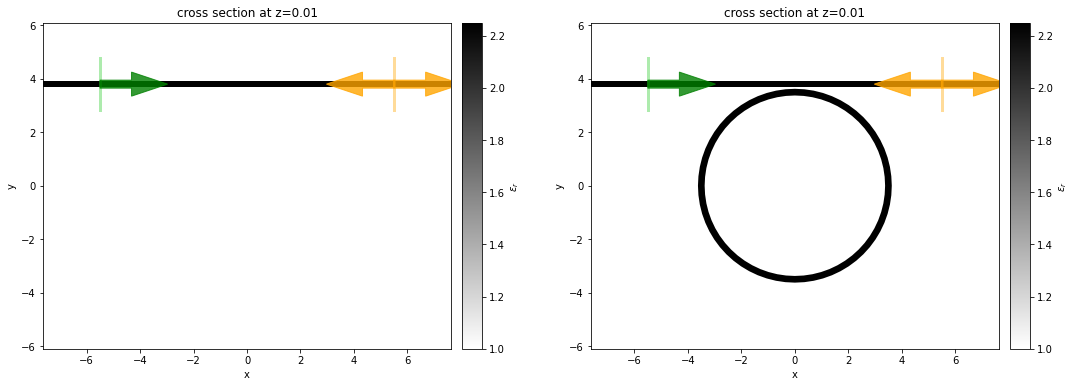

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

           INFO     Using Tidy3D credentials from stored file                      ]8;id=210584;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=363188;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[13:22:42] INFO     Uploaded task 'normalization' with task_id                  ]8;id=421985;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=927776;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'cc2cb725-0c4f-4181-89b0-78e2b64ea98a'.                                  

[13:22:47] INFO     status = queued                                             ]8;id=445981;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=157381;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[13:22:51] INFO     Maximum flex unit cost: 0.20                                ]8;id=35849;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103945;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[13:22:53] INFO     status = preprocess                                         ]8;id=672593;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=293716;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[13:23:03] INFO     starting up solver                                          ]8;id=793587;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380210;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[13:23:13] INFO     running solver                                              ]8;id=982054;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=169716;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[13:23:16] INFO     early shutoff detected, exiting.                            ]8;id=13884;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=233859;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                        ]8;id=488907;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=376332;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[13:23:35] INFO     status = success                                            ]8;id=680593;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=415037;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[13:23:37] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=724231;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=524749;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#584\584]8;;\
                    "data/simulation_data0.hdf5"                                             

Output()

[13:24:30] INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=761197;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=349531;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#407\407]8;;\

[13:24:34] INFO     Uploaded task 'with_ring' with task_id                      ]8;id=146757;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=829120;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '52fc7ca4-d9ca-42f1-a3f1-ccb9bff7d563'.                                  

[13:24:40] INFO     status = queued                                             ]8;id=69857;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=502798;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[13:24:42] INFO     Maximum flex unit cost: 0.20                                ]8;id=725877;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=658630;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

[13:24:46] INFO     status = preprocess                                         ]8;id=477082;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=642357;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[13:24:56] INFO     starting up solver                                          ]8;id=898633;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=98929;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[13:25:08] INFO     running solver                                              ]8;id=727239;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=892628;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[13:25:42] INFO     early shutoff detected, exiting.                            ]8;id=13123;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=890953;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                        ]8;id=31457;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=449738;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[13:26:03] INFO     status = success                                            ]8;id=637118;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=887206;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[13:26:05] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=923505;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=880671;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#584\584]8;;\
                    "data/simulation_data.hdf5"                                              

Output()

[13:27:14] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=172371;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=469910;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#407\407]8;;\

In [13]:
print(sim_data0.log)

Simulation domain Nx, Ny, Nz: [1375, 741, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.0189e+06.
Using subpixel averaging: True
Number of time steps: 4.7330e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 2.1135e-17

Compute source modes time (s):     0.1816
Compute monitor modes time (s):    5.6073
Rest of setup time (s):            3.6798

Starting solver...
- Time step    189 / time 3.99e-15s (  4 % done), field decay: 1.00e+00
- Time step    377 / time 7.97e-15s (  7 % done), field decay: 1.00e+00
- Time step    378 / time 7.99e-15s (  8 % done), field decay: 1.00e+00
- Time step    567 / time 1.20e-14s ( 12 % done), field decay: 1.00e+00
- Time step    757 / time 1.60e-14s ( 16 % done), field decay: 9.96e-01
- Time step    946 / time 2.00e-14s ( 20 % done), field decay: 9.96e-01
- Time step   1135 / time 2.40e-14s ( 24 % done), field decay: 9.94e-01
- Time step   1325 / time 2.80e-14s ( 28 % done), field decay: 9.94e-01
- Time step   1514 / time 3.

/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<Figure size 1080x720 with 8 Axes>

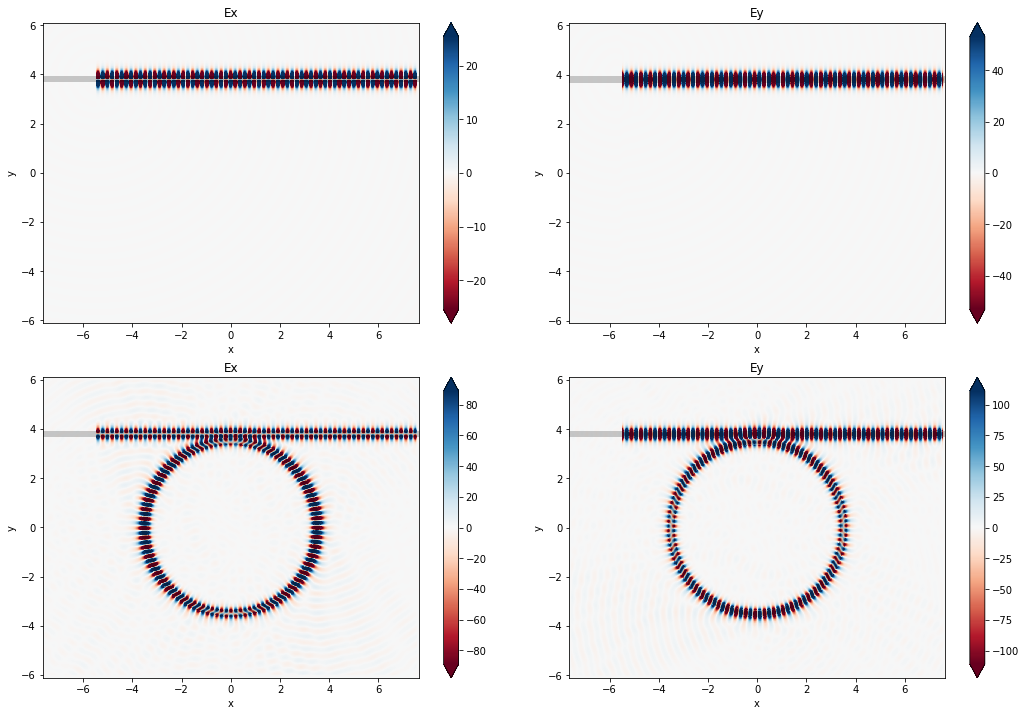

In [14]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode']

ModeData(type='ModeData', data_dict={'amps': ModeAmpsData(type='ModeAmpsData', values=array([[[ 6.52695922e-10+2.08598778e-10j,
          6.67187182e-01-7.32922056e-01j],
        [ 3.52026486e-10-4.16148863e-11j,
          5.30795071e-01-8.35485410e-01j],
        [ 2.07242731e-10-7.69945157e-11j,
          3.88862430e-01-9.08826579e-01j],
        ...,
        [-9.68465621e-11-8.70275779e-12j,
         -8.79974722e-01-4.26730745e-01j],
        [-9.34700158e-11+1.86353253e-11j,
         -9.25110323e-01-3.18559232e-01j],
        [-8.65107422e-11+4.37128469e-11j,
         -9.56228415e-01-2.08281165e-01j]],

       [[-4.45971240e-13-2.23236999e-13j,
         -7.07510458e-06+8.80674255e-06j],
        [-5.39466919e-13-1.67051600e-13j,
         -9.72364430e-06-1.52389156e-05j],
        [-5.73220690e-13-8.97230935e-14j,
          2.34609755e-06-1.52719390e-05j],
        ...,
        [-1.71540989e-14+2.31988776e-14j,
          1.51416578e-05-4.19914744e-05j],
        [-8.01234195e-15+2.78127570e-14j,
          1.07943329e-05-4.27773341e-05j],
        [-1.22097779e-14+2.14657967e-14j,
          1.25770725e-06-4.32076726e-05j]]]), data_attrs={'units': 'sqrt(W)', 'long_name': 'mode amplitudes'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]), direction=['+', '-']), 'n_complex': ModeIndexData(type='ModeIndexData', values=array([[1.39832878-8.08547459e-18j, 1.3546186 +5.38415794e-18j],
       [1.39825972+8.09087845e-18j, 1.35450388+3.17332152e-18j],
       [1.39819065-5.04168049e-18j, 1.35438915-5.89299999e-18j],
       ...,
       [1.33126784+1.50608830e-17j, 1.24254995+4.33283097e-14j],
       [1.33120393+2.09320740e-17j, 1.24244685+8.99120922e-15j],
       [1.33114003+9.98470961e-18j, 1.24234379-9.37244275e-15j]]), data_attrs={'units': '', 'long_name': 'effective index'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]))})

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [16]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

<Figure size 720x360 with 1 Axes>

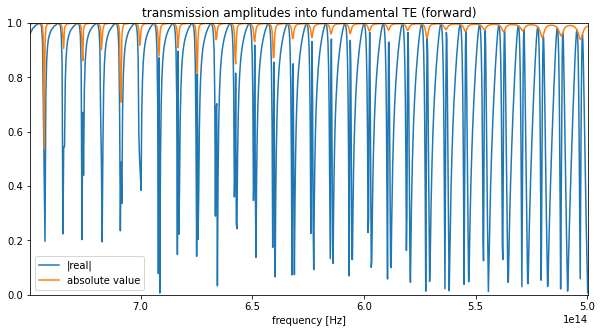

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
abs(transmission_amps.real).plot.line(x='f', ax=ax, label='|real|')
# abs(transmission_amps.imag).plot.line(x='f', ax=ax, label='|imag|')
abs(transmission_amps).plot.line(x='f', ax=ax, label='absolute value')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()